# *BEATS CT reconstruction pipeline - Manfrini*
Minimal [TomoPy](https://tomopy.readthedocs.io/en/latest/) reconstruction pipeline for **phase contrast** data collected at the [BEATS beamline](https://beats-sesame.eu/) of [SESAME](https://www.sesame.org.jo/).

Created on:  23.05.2021 <br />
Last update: 01.12.2023 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2023
- Code license: MIT
- Narrative license: CC-BY-NC-SA

Type `Ctrl` + `Enter` on a single cell to run it.

## Load experiment data
Enter the **sample_name** and the correct **output_dir** 

In [96]:
# sample_name = "1000_C_B-20231201T133645"
sample_name = "1000_C_B_360-20231201T215750"
work_dir = "/PETRA/SED/BEATS/IH/"+sample_name
h5file = work_dir+"/"+sample_name+".h5"

output_dir = "/home/beatsbs/Data/IH/scratch/"
recon_dir = output_dir+sample_name+"/recon_phase/"
cor_dir = output_dir+sample_name+"/cor/"

### Load the complete dataset (or)

In [ ]:
# projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0)

### Read a portion of the dataset
- `sino` controls the vertical detector lines to read - `sino=(10, 2161, 1)`
- `proj` defines the range of projections - `proj=(1, 401, 1)`

In [97]:
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, sino=(550, 650, 1))

print("Dataset size: ", projs[:, :, :].shape[:], " - dtype: ", projs.dtype)
print("Flat fields size: ", flats[:, :, :].shape[:])
print("Dark fields size: ", darks[:, :, :].shape[:])
print("Theta array size: ", theta.shape[:])

INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/1000_C_B_360-20231201T215750/1000_C_B_360-20231201T215750.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/1000_C_B_360-20231201T215750/1000_C_B_360-20231201T215750.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/1000_C_B_360-20231201T215750/1000_C_B_360-20231201T215750.h5
INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/1000_C_B_360-20231201T215750/1000_C_B_360-20231201T215750.h5


Dataset size:  (4001, 100, 2560)  - dtype:  uint16
Flat fields size:  (51, 100, 2560)
Dark fields size:  (51, 100, 2560)
Theta array size:  (4001,)


At any time you can take a look at your 3D data with `ru.plotmidplanes(data)`

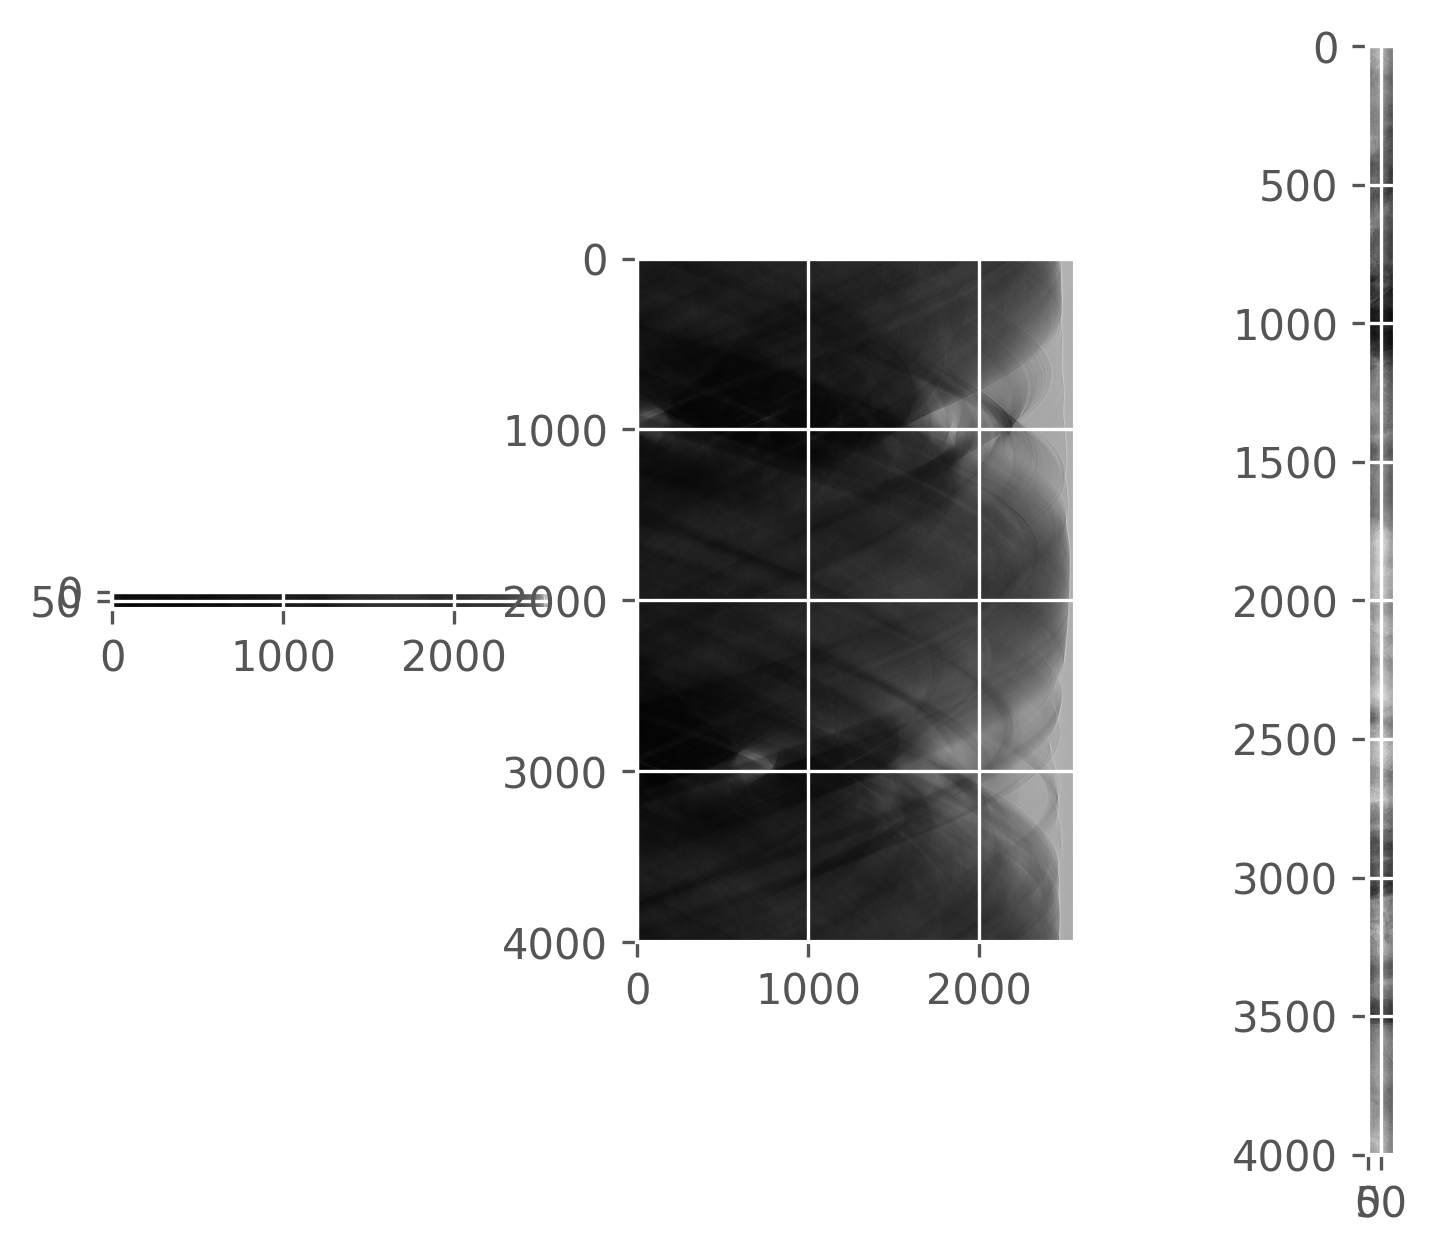

In [98]:
ru.plot_midplanes(projs)

## Flat field correction
Normalize the image background.

In [99]:
projs = tomopy.normalize(projs, flats, darks, ncore=ncore, averaging='median')

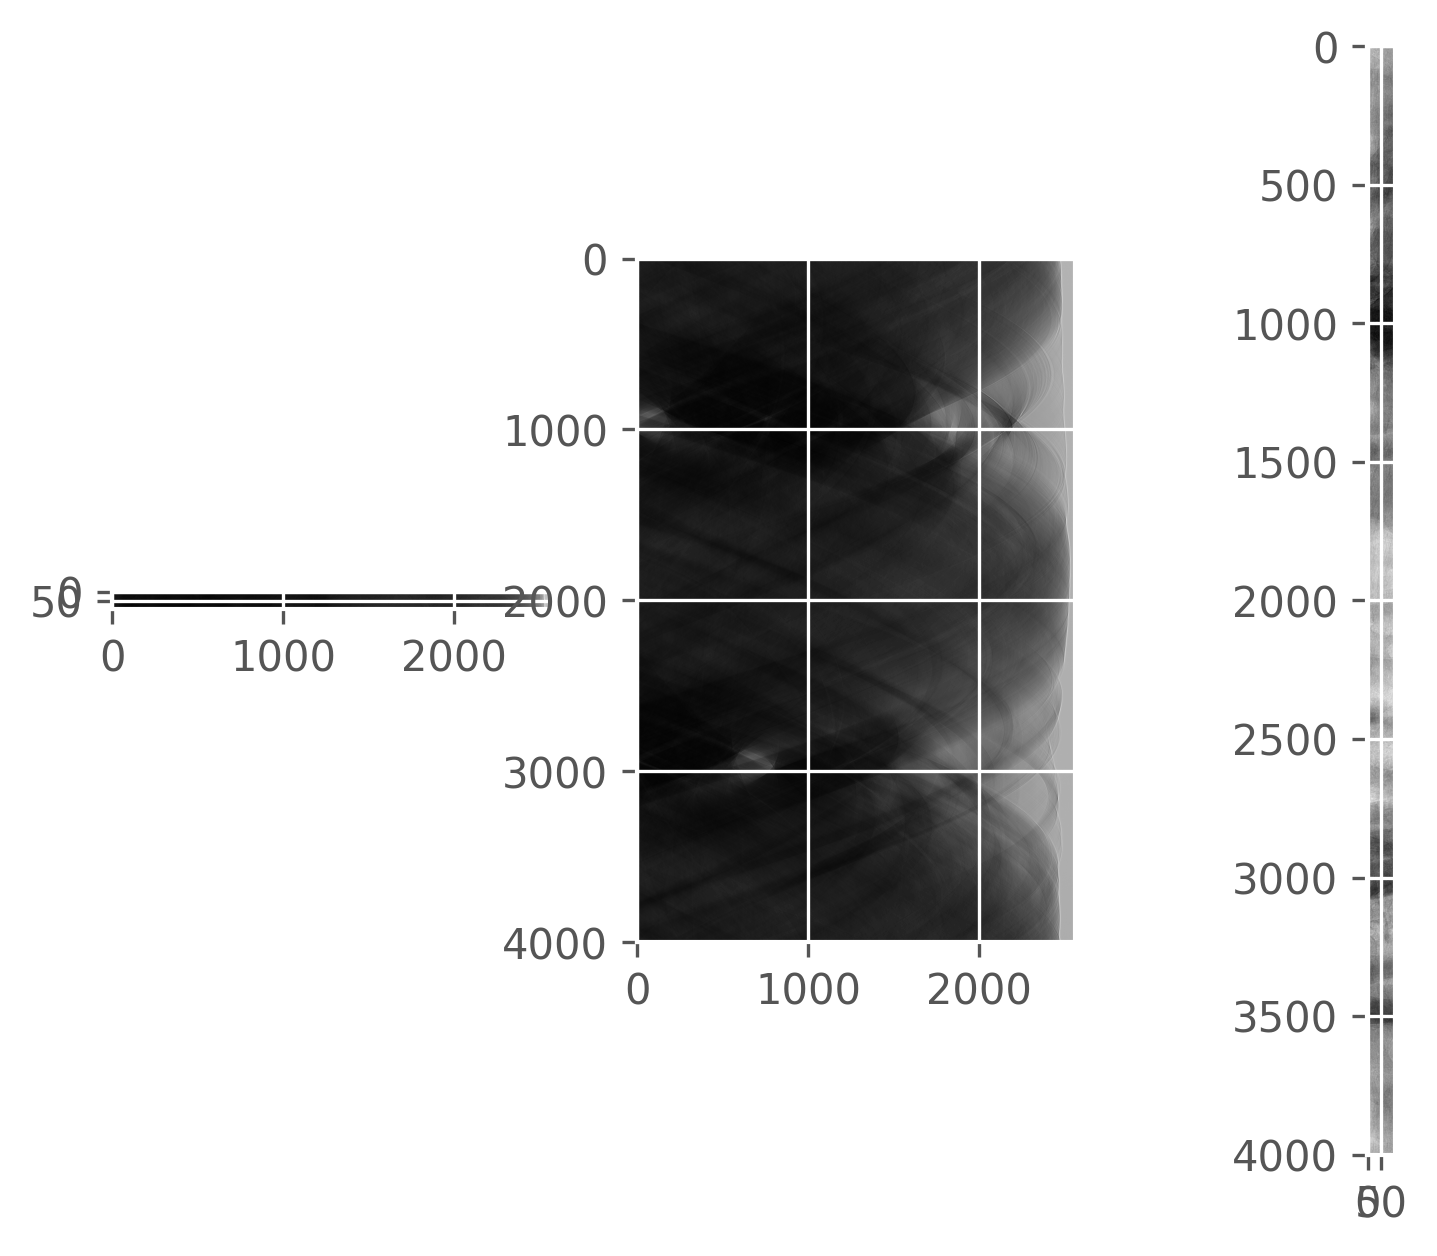

In [100]:
ru.plot_midplanes(projs)

## Convert from 360 to 180 degree sinograms

In [180]:
projs_180 = tomopy.sino_360_to_180(projs, overlap=749.5) # 154

In [182]:
COR = projs_180.shape[2]/2

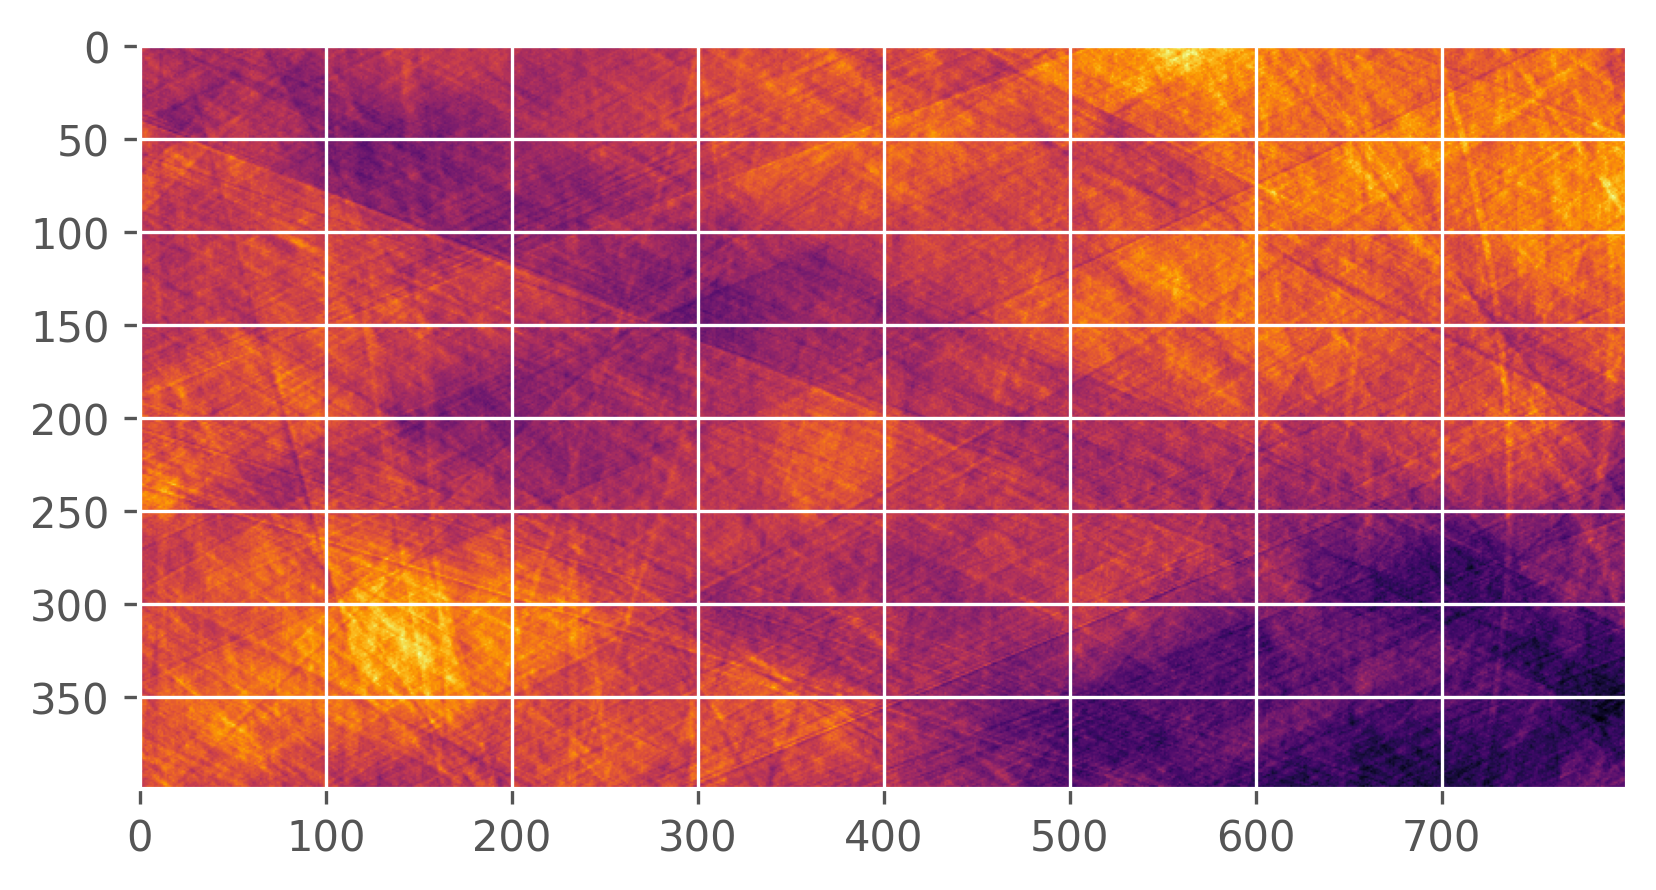

In [181]:
# ru.plot_midplanes(projs_180)
plt.imshow(projs_180[0:400, 50, 2000:2800], cmap='inferno')

## Stripe removal
`tomopy.prep.stripe.remove_all_stripe(tomo, snr=3, la_size=61, sm_size=21, dim=1, ncore=None, nchunk=None)`

https://tomopy.readthedocs.io/en/latest/api/tomopy.prep.stripe.html#tomopy.prep.stripe.remove_all_stripe

In [56]:
# projs = tomopy.prep.stripe.remove_dead_stripe(projs, ncore=ncore)
# projs = tomopy.prep.stripe.remove_large_stripe(projs, ncore=ncore)
# projs = tomopy.prep.stripe.remove_stripe_based_fitting(projs, ncore=ncore)
projs = tomopy.prep.stripe.remove_stripe_based_sorting(projs, size=31, dim=2, ncore=ncore)

## Phase retrieval

In [183]:
delta_beta = 1E-7/1E-9 # ratio between real and imaginary part of the refractive index
alpha=1./(4*3.141592**2 * delta_beta)
print("alpha: ", alpha)

alpha:  0.0002533030645022459


In [184]:
projs_phase = tomopy.retrieve_phase(projs_180[:, :, :],
                                    pixel_size=1e-4*1.3,
                                    dist=6.2,
                                    energy=25,
                                    alpha=alpha,
                                    ncore=ncore,
                                    pad=True)
# nchunk=None,

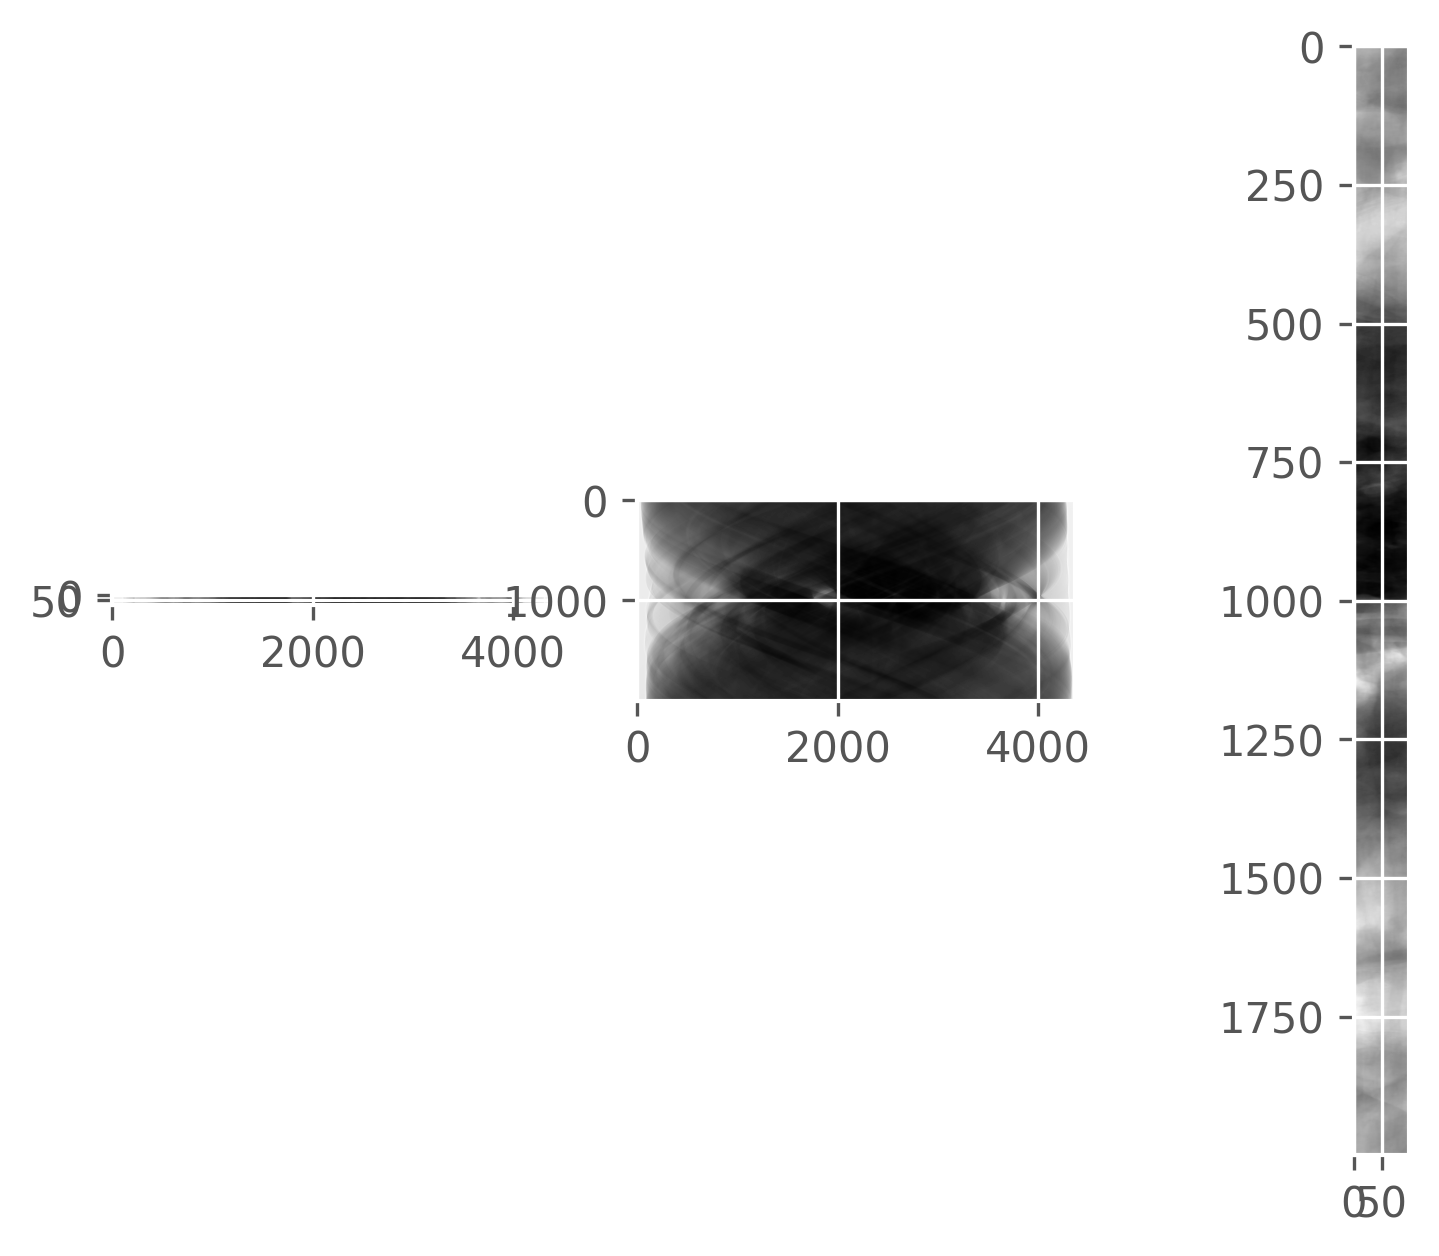

In [142]:
ru.plot_midplanes(projs_phase)

In [185]:
projs_phase = tomopy.minus_log(projs_phase, ncore=ncore)

Manually insert the best `COR`

In [92]:
COR = 1282
pad_size = 0

## Reconstruction
|  |  |
| :--- | :--- |
| **Algorithm**      | `gridrec` |

In [ ]:
# options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}

# recon = tomopy.recon(projs_phase,
#                      theta,
#                      center=COR,
#                      algorithm=tomopy.astra,
#                      options=options,
#                      ncore=1)

In [186]:
recon = tomopy.recon(projs_phase,
                     theta[:projs_phase.shape[0]],
                     center=COR+pad_size,
                     algorithm='gridrec',
                     sinogram_order=False,
                     ncore=ncore)

INFO:tomopy.recon.algorithm:Reconstructing 36 slice groups with 36 master threads...


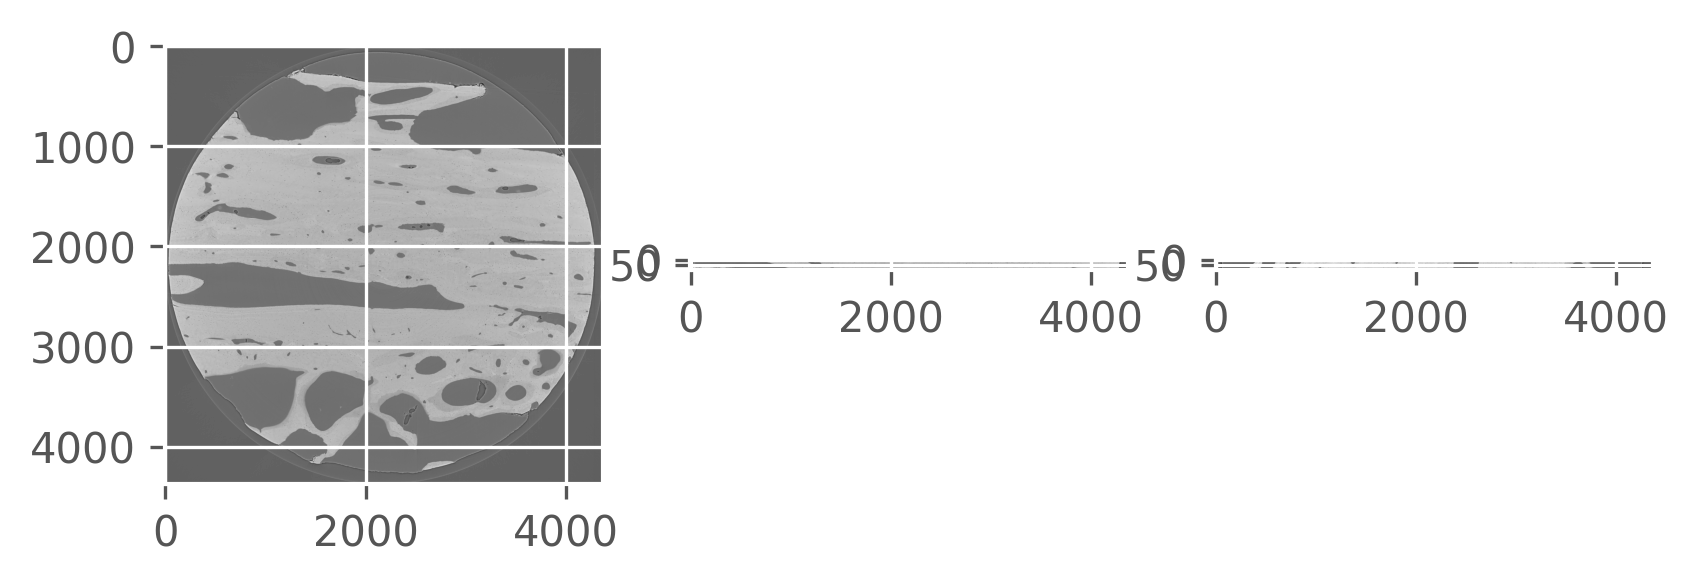

In [176]:
ru.plot_midplanes(recon)

## Write reconstructed dataset
Write output tiff stack as `float32`

In [187]:
fileout = recon_dir+'slice.tiff'
dxchange.writer.write_tiff_stack(recon, fname=fileout, axis=0, digit=4, start=0, overwrite=True)